**Train-Valid:** 2011-2019  
**Test:** 2020 and 2021

In [1]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 42.0 MB/s eta 0:00:00


## Import Packages & Data

In [2]:
!pip install -U neptune-client
import sys
import os
import numpy as np
import pandas as pd
# import calendar
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
import neptune.new as neptune 
from collections import Counter, defaultdict
import pickle
from sklearn.ensemble import StackingClassifier, BaggingClassifier,RandomForestClassifier,HistGradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
seed=42


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.4 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-2-0fcc028801e2>:12: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path
!pip install neptune-sklearn
import neptune.new.integrations.sklearn as npt_utils

Importing directly from CA4021 folder
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot

from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score,score_model

# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path,'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path,'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


In [30]:
# changing dir variable with sin transformation

df_train['dir'] = np.sin((df_train['dir']*10)*(np.pi/180))
df_test['dir'] = np.sin((df_test['dir']*10)*(np.pi/180))

In [32]:
# LEAVING OUT w, ww, pweather and weather because of OH encoding sparsity

metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df_train.columns if col[0] == 'i']
constant = [var for var in df_train.columns if len(df_train[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa', 'w' ,'ww', 'pweather', 'weather']
excluded = indicator + constant + codes + ['rgauge', 'sog', 'tabspeed', 'msl']
vis_vars=['target_hr1', 'vis_hr1', 'fog_formation', 'fog_dissipation', 'transition']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar','dir'] #'w', 'ww', 'pweather',
             #'weather']
discrete = [var for var in df_train.columns if len(df_train[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df_train.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = discrete+continuous
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']
# selected variables from XGBoost notebook
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]

dates = df_train.date_time
X = df_train[numerical + categorical + vis_vars].reset_index(drop=True)
y = X.pop(target)

# create train and test from X, without including df_test
pre_X_train, pre_X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.23, shuffle=False, random_state=seed)

# creating training sets using only the selected features
X_train, X_valid = preprocess(pre_X_train, pre_X_valid, cat_vars=cat_vars_sel, num_vars=num_vars_sel,cat_encoder='oh')

# create training data using all the variables df_train (for comparison)
X_train_all, X_test_all = preprocess(pre_X_train, pre_X_valid, cat_vars=categorical, num_vars=numerical,cat_encoder='oh')

In [33]:
pre_X_valid.head()

,clow,cmedium,chigh,nlc,ntot,nsig1,nsig2,nsig3,nsig4,tsig4,duration,sunshine,speed,vis,ptend,cbl,drybulb,wetbulb,dewpt,vp,rh,hlc,hsig1,hsig2,hsig3,hsig4,ceiling,dos,rainfall,tabdir,dni,temp_dew_dist,rainfall12hma,fog_state,season,tsig1,tsig2,tsig3,pchar,dir,vis_hr1,fog_formation,fog_dissipation,transition
60743,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,8,25000,1.7,1017.6,8.7,7.3,5.7,9.1,81,18,18,32.0,0.0,0.0,32,0.0,0.0,22,0,3.0,-8.881784e-15,no fog,winter,7,6.0,0.0,6,-0.642788,25000.0,0,0,0
60744,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,11,25000,1.6,1017.1,9.0,7.5,5.8,9.2,80,18,18,32.0,0.0,0.0,32,0.0,0.0,22,0,3.2,-8.881784e-15,no fog,winter,7,6.0,0.0,6,-0.500000,25000.0,0,0,0
60745,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,8,25000,1.7,1016.4,9.5,7.8,5.9,9.2,78,18,18,30.0,0.0,0.0,30,0.0,0.0,20,0,3.6,-8.881784e-15,no fog,winter,7,6.0,0.0,8,-0.342020,25000.0,0,0,0
60746,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,10,25000,2.0,1015.6,9.8,8.0,6.0,9.3,77,18,18,30.0,0.0,0.0,30,0.0,0.0,21,0,3.8,-8.881784e-15,no fog,winter,7,6.0,0.0,8,-0.500000,25000.0,0,0,0
60747,5.0,0.0,0.0,7,7,1,7.0,0.0,0.0,0.0,0.0,0.0,12,25000,2.3,1014.8,9.8,8.0,6.0,9.3,77,18,18,32.0,0.0,0.0,32,0.0,0.0,22,0,3.8,-8.881784e-15,no fog,winter,7,6.0,0.0,8,-0.642788,25000.0,0,0,0


In [34]:
X_valid.head()

,vis,temp_dew_dist,rh,ceiling,duration,hsig2,dni,dewpt,drybulb,cbl,hlc,ntot,speed,vp,pchar_0,pchar_1,pchar_2,pchar_3,pchar_4,pchar_5,pchar_6,pchar_7,pchar_8
60743,-0.269299,-0.004030,-0.135296,-0.284854,-0.412199,-0.266548,-0.858595,-0.256145,-0.229161,1.212983,-0.103304,0.587607,-0.514436,-0.391955,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60744,-0.269299,0.082432,-0.220337,-0.284854,-0.412199,-0.266548,-0.858595,-0.233127,-0.167896,1.171003,-0.103304,0.587607,0.016999,-0.358727,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
60745,-0.269299,0.255354,-0.390417,-0.314434,-0.412199,-0.296772,-0.858595,-0.210110,-0.065788,1.112230,-0.103304,0.587607,-0.514436,-0.358727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60746,-0.269299,0.341816,-0.475458,-0.314434,-0.412199,-0.296772,-0.858595,-0.187092,-0.004524,1.045061,-0.103304,0.587607,-0.160146,-0.325499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60747,-0.269299,0.341816,-0.475458,-0.284854,-0.412199,-0.266548,-0.858595,-0.187092,-0.004524,0.977891,-0.103304,0.587607,0.194144,-0.325499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
# for compatibility with TimeSeriesSplit
pre_X_train = pre_X_train.reset_index(drop=True)
pre_X_valid = pre_X_valid.reset_index(drop=True)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)

In [20]:
# find indices of transitions, and the index right before it
pre_X_valid[target] = y_valid
t_indices = pre_X_valid.loc[pre_X_valid['transition']==1].index
before_t_indices = t_indices - 1
t_indices = t_indices.append(before_t_indices)

# check if transition indices actually show fog state transitions
# the transition index should be 1 when there is a transition in the next hour, since we're predicting fog in the next hour
print(pre_X_valid.loc[t_indices[0]-2:t_indices[0]+2, ['fog_state', 'target_hr1', 'transition']])

    fog_state  target_hr1  transition
358    no fog           0           0
359    no fog           0           0
360    no fog           1           1
361       fog           1           0
362       fog           0           1


In [21]:
# get transition indices for scoring
assert pre_X_valid.iloc[:, -2].name == 'transition'

# the first index here is the 5th record, which is the last record of the first training sequence
# hence, the t_indices matches up with the transition indices in y_valid_seq
xv_transitions = pre_X_valid.iloc[4:, -2].reset_index(drop=True)
xv_transitions.reset_index(drop=True)


# transition indices for all the sequences in the training set.
t_indices = xv_transitions[xv_transitions==1].index
before_t_indices = t_indices - 1
t_indices = t_indices.append(before_t_indices)

In [ ]:
# check that t_indices positions actually correspond to transitions
#print(pre_X_valid.iloc[4:, :].reset_index().loc[t_indices[0]-1:t_indices[0]+2, ['fog_state', 'transition']])

### Modelling - trying out stacking first
Trying out ensembles of RF, XGB and MLP

In [23]:
# loading in parameters

with open(os.path.join(path, 'results/rf_hyperparam_search2.pickle'), 'rb') as file:
  rf_search = pickle.load(file)

xgb_best_params = {'colsample_bytree': 0.9040922615763338,
 'gamma': 0.2252496259847715,
 'learning_rate': 0.006979488347959958,
 'max_depth': 2,
 'n_estimators': 415,
 'subsample': 0.8253152871382157}

with open(os.path.join(path, 'results/mlp_hyperparam_search_random.pickle'), 'rb') as file:
  mlp_search = pickle.load(file)

In [ ]:
rf_search.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 800}

In [ ]:

#MLPClassifier(**bayes_params)
estimators = [('rf', RandomForestClassifier(**rf_search.best_params_, random_state=seed)),('xgb',XGBClassifier(**xgb_best_params,random_state=seed))]
clf = StackingClassifier(
    estimators=estimators)



Fold : 1
training size: (13148, 16)
test size: (13148, 16)
[[13029     7]
 [   70    42]]
****************************************************************************************************
Fold : 2
training size: (26296, 16)
test size: (13148, 16)
[[12956    31]
 [   68    93]]
****************************************************************************************************
Fold : 3
training size: (39444, 16)
test size: (13148, 16)
[[13033    20]
 [   39    56]]
****************************************************************************************************
Fold : 4
training size: (52592, 16)
test size: (13148, 16)
[[13045    14]
 [   52    37]]
****************************************************************************************************
Fold : 5
training size: (65740, 16)
test size: (13148, 16)
[[13080    13]
 [   37    18]]
****************************************************************************************************


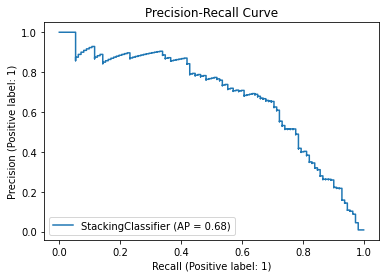

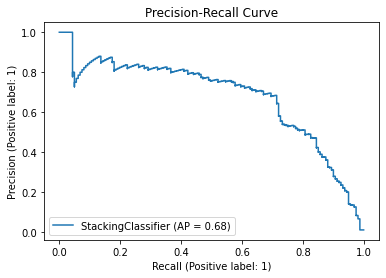

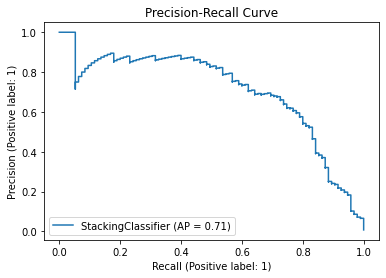

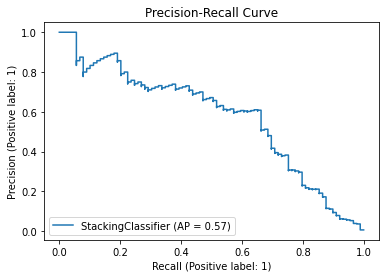

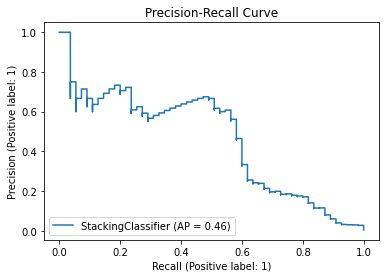

In [ ]:
validation_model_scores, _, _ = manual_cross_validate(model=clf, 
                                                 X=X, y=y,
                                                 num_vars=num_vars_sel,
                                                 cat_vars=cat_vars_sel,              
                                                 folds=5, 
                                                 calc_feature_importance=False,
                                                 cat_encoder='oe')

In [ ]:
performance_report(validation_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [52.17, 65.26, 65.5, 52.86, 41.86]
Mean: 55.530

heidke_skill_score
Scores: [0.5192, 0.6489, 0.6527, 0.5262, 0.4168]
Mean: 0.553

transition_f1_score
Scores: [26.8, 29.76, 29.79, 27.08, 22.54]
Mean: 27.194

transition_hss_score
Scores: [0.0658, -0.1346, -0.1, -0.0294, -0.1458]
Mean: -0.069

pr_auc
Scores: [0.6771, 0.6773, 0.7043, 0.5719, 0.4507]
Mean: 0.616



Fold : 1
training size: (13148, 24)
test size: (13148, 24)
[[13030     6]
 [   68    44]]
****************************************************************************************************
Fold : 2
training size: (26296, 24)
test size: (13148, 24)
[[12954    33]
 [   70    91]]
****************************************************************************************************
Fold : 3
training size: (39444, 24)
test size: (13148, 24)
[[13035    18]
 [   39    56]]
****************************************************************************************************
Fold : 4
training size: (52592, 24)
test size: (13148, 24)
[[13045    14]
 [   53    36]]
****************************************************************************************************
Fold : 5
training size: (65740, 24)
test size: (13148, 24)
[[13080    13]
 [   36    19]]
****************************************************************************************************


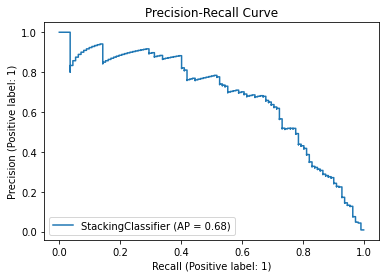

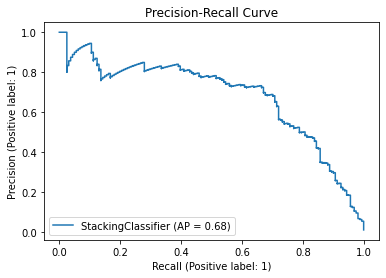

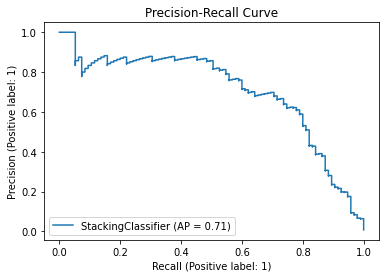

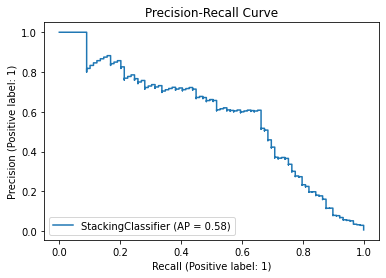

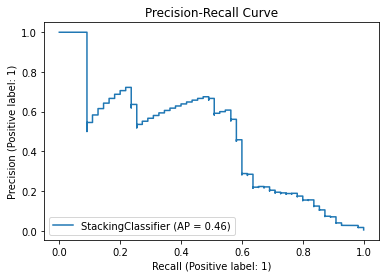

In [ ]:
validation_model_scores, _, _ = manual_cross_validate(model=clf, 
                                                 X=X, y=y,
                                                 num_vars=num_vars_sel,
                                                 cat_vars=cat_vars_sel,              
                                                 folds=5, 
                                                 calc_feature_importance=False,
                                                 cat_encoder='oh')

In [ ]:
performance_report(validation_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [54.32, 63.86, 66.27, 51.8, 43.68]
Mean: 55.986

heidke_skill_score
Scores: [0.5408, 0.6347, 0.6606, 0.5156, 0.435]
Mean: 0.557

transition_f1_score
Scores: [25.26, 28.4, 30.43, 25.26, 22.54]
Mean: 26.378

transition_hss_score
Scores: [0.0658, -0.1635, -0.0667, -0.0441, -0.1458]
Mean: -0.071

pr_auc
Scores: [0.6765, 0.6786, 0.7033, 0.5745, 0.4582]
Mean: 0.618



In [ ]:
bayes_params = {'n_iter_no_change': 100,
 'max_iter': 500,
 'batch_size': 100,
 'activation': 'logistic',
 'alpha': 1e-06,
 'hidden_layer_sizes': (762, 762),
 'early_stopping': True,
 'solver': 'adam',
 'random_state': 42}
estimators = [('rf', RandomForestClassifier(**rf_search.best_params_, random_state=seed)),('mlp',MLPClassifier(**bayes_params)),('xgb',XGBClassifier(**xgb_best_params,random_state=seed))]
clf = StackingClassifier(
    estimators=estimators)

In [ ]:
# to rerun on own machine
X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')

y_train = y.copy()
y_test = df_test[target]

clf.fit(X_train, y_train)
final_scores, final_plots = score_model(clf, X_train, X_test, y_train, y_test, df_test)
performance_report(final_scores)

### Modelling - Voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = [('rf', RandomForestClassifier(**rf_search.best_params_, random_state=seed)),('lr',LogisticRegression(max_iter=500,random_state=seed)),('xgb',XGBClassifier(**xgb_best_params,random_state=seed))]
voting = VotingClassifier(
    estimators=estimators)

validation_model_scores, _, _ = manual_cross_validate(model=voting, 
                                                 X=X, y=y,
                                                 num_vars=num_vars_sel,
                                                 cat_vars=cat_vars_sel,              
                                                 folds=5, 
                                                 calc_feature_importance=False,
                                                 cat_encoder='oh')

Fold : 1
Unable to calculate probabilities of class labels, so AUC omitted. Check that the model has the predict_proba function.
training size: (13148, 24)
test size: (13148, 24)
[[13026    10]
 [   75    37]]
****************************************************************************************************
Fold : 2
Unable to calculate probabilities of class labels, so AUC omitted. Check that the model has the predict_proba function.
training size: (26296, 24)
test size: (13148, 24)
[[12955    32]
 [   68    93]]
****************************************************************************************************
Fold : 3
Unable to calculate probabilities of class labels, so AUC omitted. Check that the model has the predict_proba function.
training size: (39444, 24)
test size: (13148, 24)
[[13036    17]
 [   41    54]]
****************************************************************************************************
Fold : 4
Unable to calculate probabilities of class labels, so AUC 

In [ ]:
performance_report(validation_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [46.54, 65.03, 65.06, 48.92, 40.48]
Mean: 53.206

heidke_skill_score
Scores: [0.4627, 0.6466, 0.6484, 0.4867, 0.403]
Mean: 0.529

transition_f1_score
Scores: [20.41, 28.57, 26.97, 28.28, 17.65]
Mean: 24.376

transition_hss_score
Scores: [-0.0263, -0.1538, -0.0833, -0.0441, -0.1667]
Mean: -0.095



### Trying Bagging with XGBoost and Random Forest

Fold : 1
training size: (13148, 24)
test size: (13148, 24)
[[13010    26]
 [   49    63]]
****************************************************************************************************
Fold : 2
training size: (26296, 24)
test size: (13148, 24)
[[12945    42]
 [   54   107]]
****************************************************************************************************
Fold : 3
training size: (39444, 24)
test size: (13148, 24)
[[13029    24]
 [   36    59]]
****************************************************************************************************
Fold : 4
training size: (52592, 24)
test size: (13148, 24)
[[13040    19]
 [   48    41]]
****************************************************************************************************
Fold : 5
training size: (65740, 24)
test size: (13148, 24)
[[13079    14]
 [   28    27]]
****************************************************************************************************


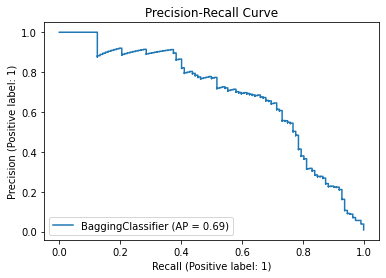

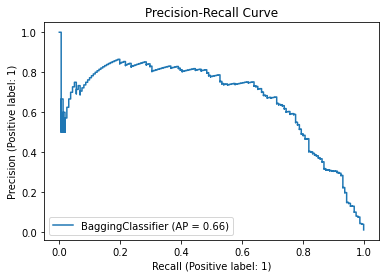

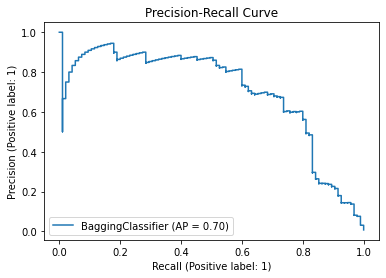

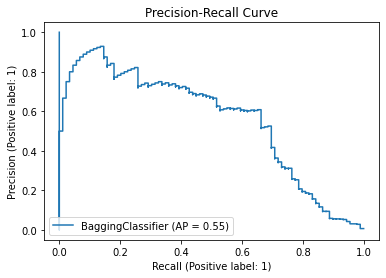

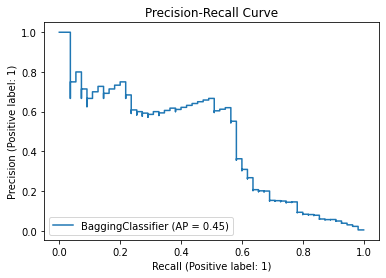

In [ ]:
#running grid search independently to determine n of estimators - this will be our best model

model = BaggingClassifier(estimator=XGBClassifier(**xgb_best_params,random_state=seed),n_estimators=100)

validation_model_scores, _, _ = manual_cross_validate(model=model, 
                                                 X=X, y=y,
                                                 num_vars=num_vars_sel,
                                                 cat_vars=cat_vars_sel,              
                                                 folds=5, 
                                                 calc_feature_importance=False,
                                                 cat_encoder='oh')

In [ ]:
performance_report(validation_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [62.69, 69.03, 66.29, 55.03, 56.25]
Mean: 61.858

heidke_skill_score
Scores: [0.624, 0.6866, 0.6606, 0.5479, 0.5609]
Mean: 0.616

transition_f1_score
Scores: [30.4, 32.43, 28.57, 30.77, 24.66]
Mean: 29.366

transition_hss_score
Scores: [-0.1447, -0.2019, -0.1667, -0.0588, -0.1458]
Mean: -0.144

pr_auc
Scores: [0.6859, 0.6615, 0.6972, 0.546, 0.4404]
Mean: 0.606



Fold : 1
training size: (13148, 24)
test size: (13148, 24)
[[13028     8]
 [   80    32]]
****************************************************************************************************
Fold : 2
training size: (26296, 24)
test size: (13148, 24)
[[12958    29]
 [   74    87]]
****************************************************************************************************
Fold : 3
training size: (39444, 24)
test size: (13148, 24)
[[13033    20]
 [   41    54]]
****************************************************************************************************
Fold : 4
training size: (52592, 24)
test size: (13148, 24)
[[13046    13]
 [   57    32]]
****************************************************************************************************
Fold : 5
training size: (65740, 24)
test size: (13148, 24)
[[13082    11]
 [   38    17]]
****************************************************************************************************
Validation Scores
---------------------------

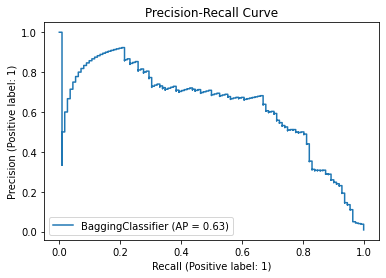

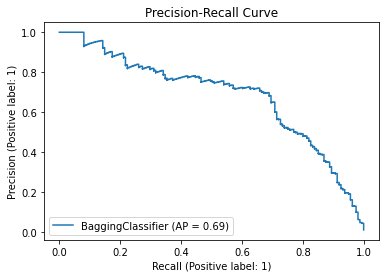

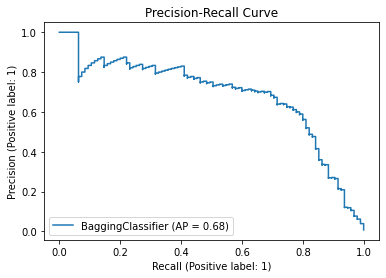

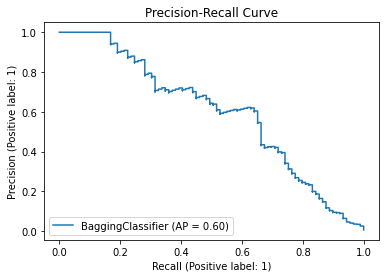

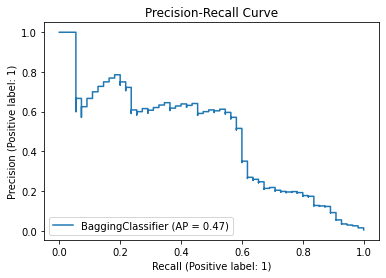

In [ ]:


model_2 = BaggingClassifier(estimator=RandomForestClassifier(**rf_search.best_params_, random_state=seed))

validation_model_scores, _, _ = manual_cross_validate(model=model_2, 
                                                 X=X, y=y,
                                                 num_vars=num_vars_sel,
                                                 cat_vars=cat_vars_sel,              
                                                 folds=5, 
                                                 calc_feature_importance=False,
                                                 cat_encoder='oh')
performance_report(validation_model_scores)

### Trying the histgradientboost classifier

Fold : 1
training size: (13148, 24)
test size: (13148, 24)
[[13007    29]
 [   48    64]]
****************************************************************************************************
Fold : 2
training size: (26296, 24)
test size: (13148, 24)
[[12937    50]
 [   67    94]]
****************************************************************************************************
Fold : 3
training size: (39444, 24)
test size: (13148, 24)
[[13027    26]
 [   33    62]]
****************************************************************************************************
Fold : 4
training size: (52592, 24)
test size: (13148, 24)
[[13041    18]
 [   47    42]]
****************************************************************************************************
Fold : 5
training size: (65740, 24)
test size: (13148, 24)
[[13076    17]
 [   30    25]]
****************************************************************************************************
Validation Scores
---------------------------

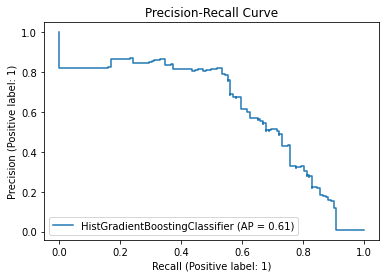

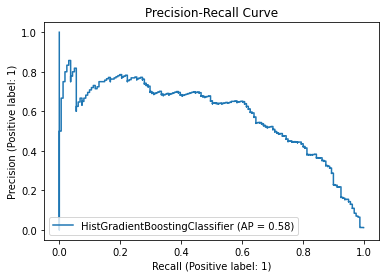

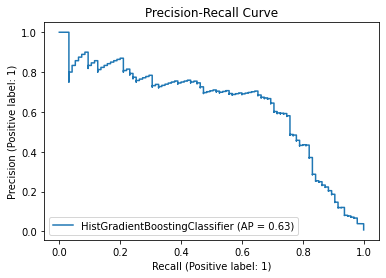

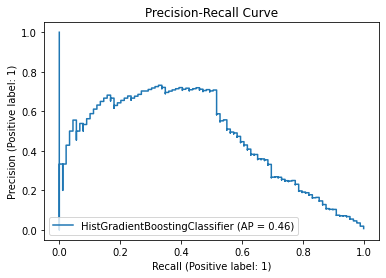

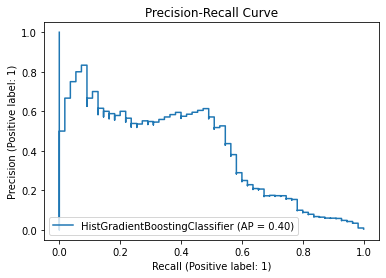

In [ ]:

# with default parameters
temp = HistGradientBoostingClassifier(random_state=seed)

validation_model_scores, _, _ = manual_cross_validate(model=temp, 
                                                 X=X, y=y,
                                                 num_vars=num_vars_sel,
                                                 cat_vars=cat_vars_sel,              
                                                 folds=5, 
                                                 calc_feature_importance=False,
                                                 cat_encoder='oh')
performance_report(validation_model_scores)
                                      

In [ ]:
# carrying out grid search
parameters = {
 'max_iter': [1000],
 'learning_rate': [0.01,0.05],
 'max_depth' : [5,7],
 'l2_regularization': [0.5,0.2]
 }
#instantiate the gridsearch
histboost = HistGradientBoostingClassifier(random_state=seed)
hgb_grid = GridSearchCV(histboost, parameters, verbose=2,
 cv=TimeSeriesSplit(n_splits = 5),return_train_score=True)
hgb_grid.fit(X_train, y_train)
hgb_grid.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END l2_regularization=0.5, learning_rate=0.01, max_depth=5, max_iter=1000; total time=   1.5s
[CV] END l2_regularization=0.5, learning_rate=0.01, max_depth=5, max_iter=1000; total time=   1.4s
[CV] END l2_regularization=0.5, learning_rate=0.01, max_depth=5, max_iter=1000; total time=   1.6s
[CV] END l2_regularization=0.5, learning_rate=0.01, max_depth=5, max_iter=1000; total time=   3.3s
[CV] END l2_regularization=0.5, learning_rate=0.01, max_depth=5, max_iter=1000; total time=   5.9s
[CV] END l2_regularization=0.5, learning_rate=0.01, max_depth=7, max_iter=1000; total time=   0.9s
[CV] END l2_regularization=0.5, learning_rate=0.01, max_depth=7, max_iter=1000; total time=   1.3s
[CV] END l2_regularization=0.5, learning_rate=0.01, max_depth=7, max_iter=1000; total time=   2.1s
[CV] END l2_regularization=0.5, learning_rate=0.01, max_depth=7, max_iter=1000; total time=   2.8s
[CV] END l2_regularization=0.5, learning_rate=0.0

{'l2_regularization': 0.5,
 'learning_rate': 0.01,
 'max_depth': 5,
 'max_iter': 1000}

Fold : 1
training size: (13148, 24)
test size: (13148, 24)
[[13018    18]
 [   72    40]]
****************************************************************************************************
Fold : 2
training size: (26296, 24)
test size: (13148, 24)
[[12951    36]
 [   62    99]]
****************************************************************************************************
Fold : 3
training size: (39444, 24)
test size: (13148, 24)
[[13030    23]
 [   35    60]]
****************************************************************************************************
Fold : 4
training size: (52592, 24)
test size: (13148, 24)
[[13044    15]
 [   50    39]]
****************************************************************************************************
Fold : 5
training size: (65740, 24)
test size: (13148, 24)
[[13080    13]
 [   29    26]]
****************************************************************************************************
Validation Scores
---------------------------

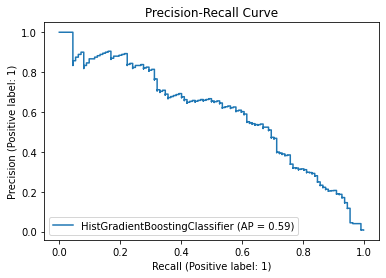

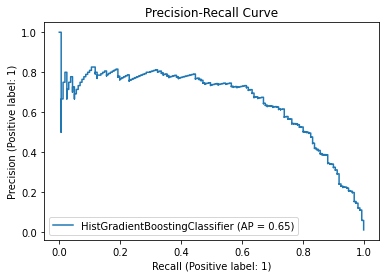

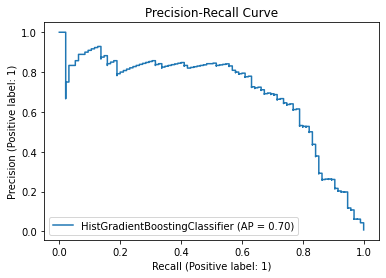

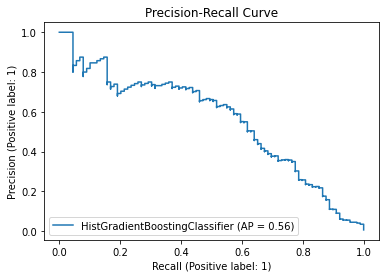

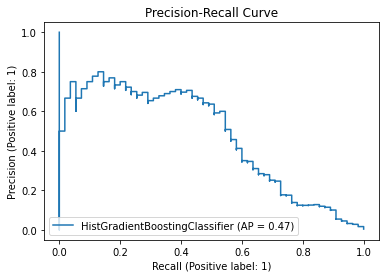

In [ ]:

params = {'l2_regularization': 0.5,
 'learning_rate': 0.01,
 'max_depth': 5,
 'max_iter': 1000}
temp = HistGradientBoostingClassifier(**params,random_state=seed)

validation_model_scores, _, _ = manual_cross_validate(model=temp, 
                                                 X=X, y=y,
                                                 num_vars=num_vars_sel,
                                                 cat_vars=cat_vars_sel,              
                                                 folds=5, 
                                                 calc_feature_importance=False,
                                                 cat_encoder='oh')
performance_report(validation_model_scores)

### Final evaluation
So far best model is bagging with XGBoost

**Note** 

Carried out grid search for optimal number of estimators of Bagging Classifier, and 100 turned out to be best. I am using the hyperparameters from grid search done for normal XGBoost below. I'm running hyperparameter search for XGBoost inside Bagging Classifier to see if there is any change, if there is, I will update results below.



Validation Scores
------------------------------
pr_auc
Score: 0.6126

f1
Score: 67.16

hss
Score: 0.6691

confusion_matrix
Score: [[17364    32]
 [   57    91]]

transition_f1
Score: 30.49

transition_hss
Score: -0.0962



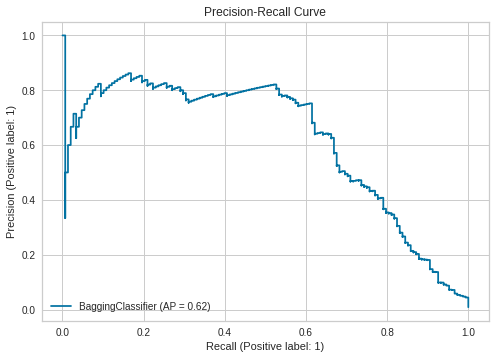

In [ ]:

X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')

y_train = y.copy()
y_test = df_test[target]


final_model = BaggingClassifier(estimator=XGBClassifier(**xgb_best_params,random_state=seed),n_estimators=100,random_state=seed)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_scores, final_plots = score_model(final_model, X_train, X_test, y_train, y_test, df_test)
performance_report(final_scores)

<ipython-input-14-115b7564f5e0>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/swiatej2/fyp/e/FYP-66
Validation Scores
------------------------------
pr_auc
Score: 0.6126

f1
Score: 67.16

hss
Score: 0.6691

confusion_matrix
Score: [[17364    32]
 [   57    91]]

transition_f1
Score: 30.49

transition_hss
Score: -0.0962



<ipython-input-14-115b7564f5e0>:19: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'list'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['features'] = vars_sel


Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/e/FYP-66/metadata


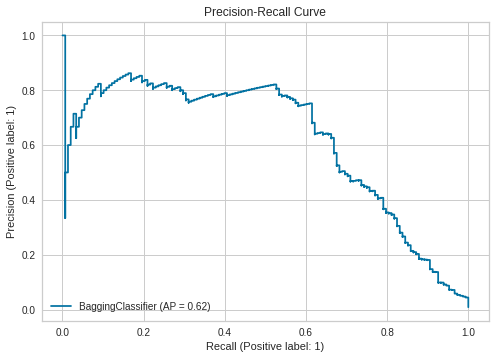

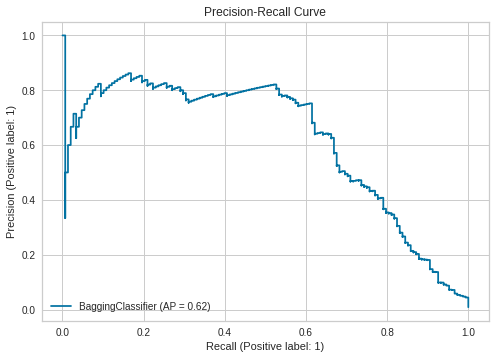

In [ ]:
run = neptune.init_run(
    project='swiatej2/fyp',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==',
    name='Bagged XGB',
    description='Bagged XGBoost',

)

final_scores, final_plots = score_model(final_model, X_train, X_test, y_train, y_test, df_test)

performance_report(final_scores)

run["algorithm"] = 'Bagged_XGBoost'
run["params"] = xgb_best_params
run['metrics/f1'] = final_scores['f1']
run['metrics/hss'] = final_scores['hss']
run['metrics/transition_f1'] = final_scores['transition_f1']
run['metrics/transition_hss'] = final_scores['transition_hss']
run['features'] = vars_sel

# only include this for compatible models
run['metrics/pr_auc'] = final_scores['pr_auc']

# save Precision-Recall curve plot
img_path = os.path.join(path, 'images/xgb_pr_curve.png')
final_plots['pr_plot'].plot()
plt.title("Precision-Recall Curve")
plt.savefig(img_path)

run['plots/pr_curve'].upload(img_path)

run['plots/confusion_matrix'] = npt_utils.create_confusion_matrix_chart(final_model, X_train, X_test, y_train, y_test)

run.stop()